## EDA on Police Training and Department Policy

- Compile information on police training and department policy (such as use of body cameras) across the Washington post dataset and BJS police academy datasets

- Perform preliminary EDA on the relationship between training/policy and police violence in different geographic regions

Washington Post dataset has info on body_camera usage of police officers during fatal incidents

In [1]:
# import packages 
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import re
import requests
from time import sleep
from bs4 import BeautifulSoup


## Part 1.1: Body Camera Usage in the Washington Post Dataset

In [2]:
# load Washington Post dataset
wapo = pd.read_csv('data/fatal-police-shootings-data.csv')

In [3]:
# display head to see revelant fields
display(wapo.head())
print(f'Shape of df: {wapo.shape}')

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


Shape of df: (5772, 17)


In [4]:
# look at in what percent of incidencets the police officers had body cameras
overall_percent_body_cam=np.mean((wapo.body_camera==True)*1)*100
print(f'The police officers wore body cameras in {overall_percent_body_cam:.2f}% \
of the fatal police shooting incidents in this dataset.')

The police officers wore body cameras in 12.18% of the fatal police shooting incidents in this dataset.


In [5]:
# print out how many cities/states we have
print(f'Number of cities: {len(wapo.city.unique())}')
print(f'Number of states: {len(wapo.state.unique())}')

Number of cities: 2582
Number of states: 51


## normalize fatal police shooting by state population

In [6]:
# KA's code
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

state_totals = wapo['state'].value_counts().sort_index()

state_populations = pd.read_csv('data/state-populations-est2019.csv')
state_populations = state_populations[['NAME', 'POPESTIMATE2019']].iloc[5:56,:]
state_populations.NAME = [us_state_abbrev[key] for key in list(state_populations.NAME)]
state_populations = state_populations.sort_values(by=['NAME'])

### State-level analysis

In [7]:
# how does body cam usage vary with geographic location (state level)
# create a new df named state_bodycam where for each state, we have total number of incidents and body cam usage
state_df=wapo.groupby('state').size().to_frame(name='total').copy()
state_df['body_cam_used']=wapo.groupby('state')['body_camera'].value_counts().unstack(fill_value=0)[True].copy()

# create new column of percent body cam used
state_df['percent_body_cam_used']=100*state_df['body_cam_used']/state_df['total']

# add population info to state_df
# since everything is sorted by alphabetical order of state names, can just add the column of state_populations.POPESTIMATE2019
state_df['population']=state_populations.POPESTIMATE2019.values.copy()

# sort by percent body cam used and display first 10 rows
state_df.sort_values(by='percent_body_cam_used',ascending=False).head(10)

,total,body_cam_used,percent_body_cam_used,population
state,,,,
VT,9,3,33.333333,623989
NV,106,35,33.018868,3080156
MN,64,21,32.812500,5639632
UT,72,22,30.555556,3205958
DC,14,4,28.571429,705749
MD,83,22,26.506024,6045680
RI,4,1,25.000000,1059361
ID,43,8,18.604651,1787065
IA,35,6,17.142857,3155070


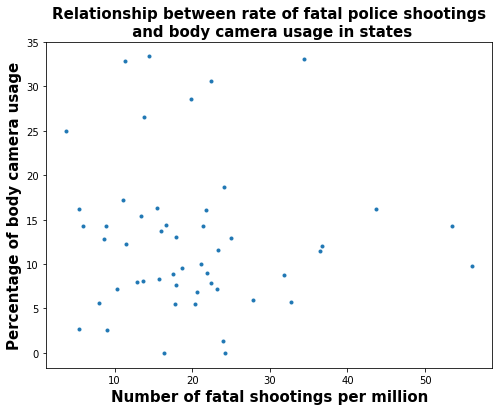

In [9]:
# how does percent_body_cam_used relate to rate of fatal incidents?
state_df['num_per_million']=1000000*state_df['total']/state_df['population']

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(state_df['num_per_million'],state_df['percent_body_cam_used'],'.')
ax.set_title('Relationship between rate of fatal police shootings\n and body camera usage in states',fontweight='bold',fontsize=15)
ax.set_xlabel('Number of fatal shootings per million',fontweight='bold',fontsize=15)
ax.set_ylabel('Percentage of body camera usage',fontweight='bold',fontsize=15);

In [10]:
r_state=np.corrcoef(state_df['num_per_million'],state_df['percent_body_cam_used'])[0,1]
print(f'Correltaion coefficient between number of fatal shootings per million and body camera usage is {r_state:.4f}')

Correltaion coefficient between number of fatal shootings per million and body camera usage is -0.0337


We see a very weak negative correlation between the rate of fatal police shootings and body camera usage. This correlation is inconclusive but suggests that: 1) states where fatal police shootings occur frequently (>35 cases per million population) may lack policies/enforcement on body camera usage and appropriate use of police; 2) states where fatal police shootings occur rarely may lack the incentive to deploy body cameras; and 3) high deployment of body cameras (>20% usage) may deter police shootings. 

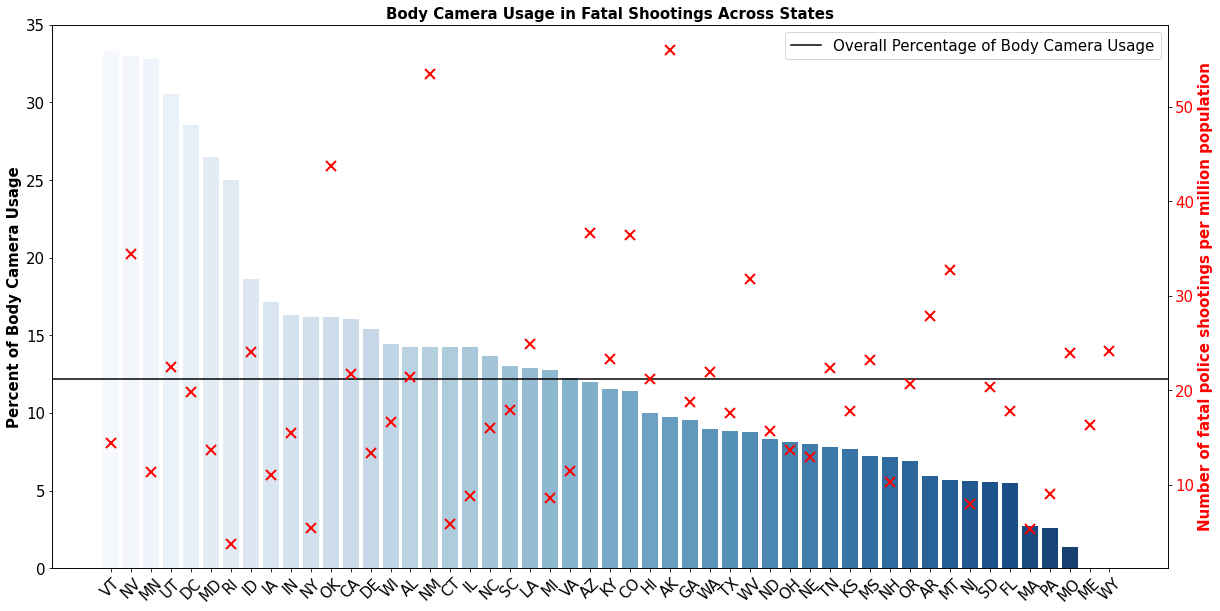

In [88]:
# display sorted bar graph of percent_body_cam_used in descending order of states
fig,ax=plt.subplots(figsize=(20,10))
order = state_df['percent_body_cam_used'].sort_values(ascending=False).index
sns.barplot(x=state_df.index,y=state_df['percent_body_cam_used'], order=order, ax=ax, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=15);
ax.set_xlabel('')
ax.set_ylabel('Percent of Body Camera Usage',fontweight='bold',fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Body Camera Usage in Fatal Shootings Across States',fontweight='bold',fontsize=15);
# draw a horizontal line of overall avg in the dataset
ax.axhline(y=overall_percent_body_cam,color='k',label='Overall Percentage of Body Camera Usage')
ax.legend(fontsize=15);

# second y axis showing shootings per million population 
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(order,state_df['num_per_million'][order],'x',color='r',markersize=10,markeredgewidth=2)
ax2.tick_params(axis='y', labelcolor='r',labelsize=15)
ax2.set_ylabel('Number of fatal police shootings per million population',fontweight='bold',fontsize=15,color='r');

#plt.savefig('State percent body cam usage blue & red.png')

### body cam usage over time
*This is the only time analysis in the notebook, since with LEMAS we don't really get the time component but a snapshot of 2016*

In [17]:
# check how overall usage of body cameras vary with time 
year=pd.DatetimeIndex(wapo['date']).year
wapo.groupby(year)['body_camera'].value_counts()
year_bodycam=wapo.groupby(year).size().to_frame(name='total')
year_bodycam['body_cam_used']=wapo.groupby(year)['body_camera'].value_counts().unstack(fill_value=0)[True]
year_bodycam['percent_body_cam_used']=100*year_bodycam['body_cam_used']/year_bodycam['total']
year_bodycam

,total,body_cam_used,percent_body_cam_used
date,,,
2015,994,75,7.545272
2016,961,146,15.192508
2017,986,106,10.750507
2018,990,118,11.919192
2019,999,134,13.413413
2020,842,124,14.726841


Note that roughly the number of fatal shootings is similar for each complete year (excluding 2020). 

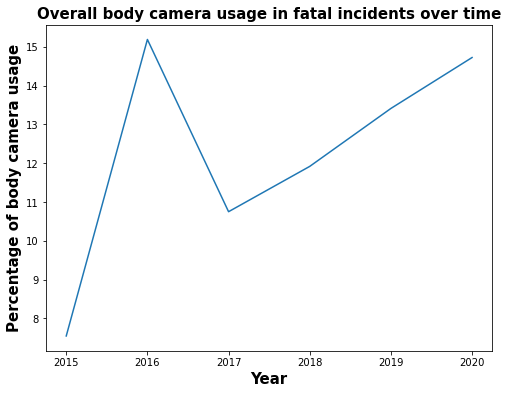

In [18]:
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(year_bodycam.index,year_bodycam['percent_body_cam_used'])
ax.set_title('Overall body camera usage in fatal incidents over time',fontweight='bold',fontsize=15)
ax.set_xlabel('Year',fontweight='bold',fontsize=15)
ax.set_ylabel('Percentage of body camera usage',fontweight='bold',fontsize=15);

Overall there is an increasing trend of body camera usage from 2015 to 2020. 2016 is an outlier with much higher body camera usage in fatal incidents. It's possible that these fatal shootings occur in different places with differing body camera policies. 

In [19]:
# display top 5 states with fatal shootings of each year
n_toshow=5
for this_year in year.unique():
    print(f'\nIn {this_year}, states with the top {n_toshow} fatal police shootings are: ')
    display(wapo.groupby(year)['state'].value_counts()[this_year][:n_toshow])


In 2015, states with the top 5 fatal police shootings are: 


state
CA    190
TX    100
FL     61
AZ     42
OK     32
Name: state, dtype: int64


In 2016, states with the top 5 fatal police shootings are: 


state
CA    138
TX     81
FL     60
AZ     50
NC     33
Name: state, dtype: int64


In 2017, states with the top 5 fatal police shootings are: 


state
CA    161
TX     69
FL     58
AZ     44
WA     38
Name: state, dtype: int64


In 2018, states with the top 5 fatal police shootings are: 


state
CA    114
TX     85
FL     64
AZ     62
CO     44
Name: state, dtype: int64


In 2019, states with the top 5 fatal police shootings are: 


state
CA    135
TX    108
FL     64
GA     37
CO     36
Name: state, dtype: int64


In 2020, states with the top 5 fatal police shootings are: 


state
CA    120
FL     76
TX     66
CO     39
AZ     34
Name: state, dtype: int64

States with the most fatal police shooting seem to be pretty consistently CA, FL, TX, and AZ. CO also has a high number of fatal police shootings. 

### City-level analysis

It would be hard to analyze each of the 2573 cities in a meaningful way. It seems like we have a long tail of cities that only occur once, but also a set of cities with a lot of fatal police shootings. If we want to do some city-level analysis, it makes more sense to focus on cities where most fatal police shooting occurs (ideally normalized to city population).

In [20]:
pd_100_shootings = {}
pd_100_bodycam={} # how many times body cameras are used

city_df = pd.read_csv('data/use-of-force.csv') # was called use of force

for city in city_df['Police Department'].values:
    if city in wapo.groupby('city').size().index:
        pd_100_shootings[city] = (wapo.groupby('city').size()[city])
        pd_100_bodycam[city] = wapo.groupby('city')['body_camera'].value_counts().unstack(fill_value=0)[True][city]
    elif city in (wapo['city']+ ', '+ wapo['state']).values: # Kansas City, MO
        pd_100_shootings[city] = (len(wapo[(wapo['city']+ ', '+ wapo['state']) == city]))
        pd_100_bodycam[city] = sum(wapo[(wapo['city']+ ', '+ wapo['state']) == city]['body_camera']==True)
    elif city in (wapo['city']+ ' '+ wapo['state']).values: # Washington DC
        pd_100_shootings[city] = (len(wapo[(wapo['city']+ ' '+ wapo['state']) == city]))
        pd_100_bodycam[city] = sum(wapo[(wapo['city']+ ' '+ wapo['state']) == city]['body_camera']==True)    

# city_pop = pd.read_csv('/Users/kamranahmed/Downloads/cities.csv')
# use_of_force['POP'] = city_pop['POP']

city_df = city_df.join(pd.DataFrame(pd_100_shootings.values(), index=pd_100_shootings.keys(), columns=['Number of shootings']), on='Police Department')
city_df = city_df.join(pd.DataFrame(pd_100_bodycam.values(), index=pd_100_bodycam.keys(), columns=['Number of body cam usage']), on='Police Department')
city_df['percent body cam used']=100*city_df['Number of body cam usage']/city_df['Number of shootings']
city_df['shootings per 1M'] = (city_df['Number of shootings']/city_df['Total Population'])*1000000
city_df = city_df.sort_values(by=['shootings per 1M'], ascending=False)

In [22]:
# city_df is missing state info
# scrape for it 

base_url = 'http://useofforceproject.org/database'
home_page = requests.get(base_url)
print(home_page.status_code)

200


In [23]:
# create beautiful soup object to parse with
bs_page = BeautifulSoup(home_page.content, "html.parser")
bs_page

<!DOCTYPE html>

<html class="" lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<!-- This is Squarespace. --><!-- samuel-sinyangwe-mex1 -->
<base href=""/>
<meta charset="utf-8">
<title>Use of Force Policy Database — Police Use of Force Project</title>
<link href="https://images.squarespace-cdn.com/content/v1/56996151cbced68b170389f4/1452970142805-MCO6GXY6T4CD4VYOQCVP/ke17ZwdGBToddI8pDm48kB3TQoBvsYLW1xqM1m8cIGZZw-zPPgdn4jUwVcJE1ZvWEtT5uBSRWt4vQZAgTJucoTqqXjS3CfNDSuuf31e0tVFx1_pJhItLEaushQcjTIPmeF99E-9vHQ2AW2fwKplduT-3CTWZQ124CTRPXn-dnvM/favicon.ico?format=100w" rel="shortcut icon" type="image/x-icon"/>
<link href="http://useofforceproject.org/database" rel="canonical"/>
<meta content="Police Use of Force Project" property="og:site_name">
<meta content="Use of Force P

In [24]:
#get all foia requests
foia_urls = {}

# YOUR CODE HERE
for link in bs_page.findAll('a', attrs={'href': re.compile("/www.muckrock.com/foi/")}):
    foia_urls[re.search(r'foi/\D*',link.get('href')).group()] = link.get('href')
    # keep a bit more of the pattern, can prune later if needed
foia_urls 
# END OF YOUR CODE HERE

{'foi/albuquerque-': 'https://www.muckrock.com/foi/albuquerque-343/use-of-force-policy-albuquerque-police-department-18620/',
 'foi/anaheim-': 'https://www.muckrock.com/foi/anaheim-187/use-of-force-policy-anaheim-police-department-18612/',
 'foi/anchorage-': 'https://www.muckrock.com/foi/anchorage-8834/use-of-force-policy-anchorage-police-department-18939/',
 'foi/arlington-': 'https://www.muckrock.com/foi/arlington-110/use-of-force-policy-arlington-police-department-18605/',
 'foi/atlanta-': 'https://www.muckrock.com/foi/atlanta-325/use-of-force-policy-atlanta-police-department-18636/',
 'foi/aurora-': 'https://www.muckrock.com/foi/aurora-364/use-of-force-policy-aurora-police-department-18639/',
 'foi/austin-': 'https://www.muckrock.com/foi/austin-139/use-of-force-policy-austin-police-department-18651/',
 'foi/bakersfield-': 'https://www.muckrock.com/foi/bakersfield-3105/use-of-force-policy-bakersfield-police-department-18932/',
 'foi/baltimore-': 'https://www.muckrock.com/foi/baltimo

In [25]:
city_state={}
manual_check=[]
for city, url in foia_urls.items():
    
    # YOUR CODE HERE
    city_bs = BeautifulSoup(requests.get(url).content, "html.parser")
    if len(city_bs.find_all('a',attrs={'href':re.compile('/place/united-states-of-america/')}))==2:
        city_name=city_bs.find_all('a',attrs={'href':re.compile('/place/united-states-of-america/')})[0].text
        state_name=city_bs.find_all('a',attrs={'href':re.compile('/place/united-states-of-america/')})[1].text
        city_state[city_name]=state_name
    else:
        manual_check.append(city)
        
    sleep(2)

In [26]:
manual_check
# seems like the links we failed to pull are not actually cities

['foi/nevada-', 'foi/norfolk-county-', 'foi/sacramento-', 'foi/mylist/?page=']

In [27]:
missing_cities=city_df['Police Department'].values[np.where(1-np.isin(city_df['Police Department'].values,np.array(list(city_state.keys()))))]
missing_cities

array(['San Bernardino', 'Miami', 'Kansas City, MO', 'Phoenix',
       'Baton Rouge', 'Henderson', 'Sacramento', 'St. Paul', 'Garland',
       'Norfolk', 'North Las Vegas', 'Cincinnati', 'Washington DC',
       'Charlotte', 'Seattle', 'St. Petersburg', 'Minneapolis', 'Toledo',
       'Detroit', 'New York'], dtype=object)

In [28]:
# the websites are not structured 100% the same, we somehow fail to automatically scrap some cities
# manually go to the webpage and find out which states these are
# if FOIA request link defunct, look into use of force document to find state info
city_state['San Bernardino']='CA'
city_state['Miami']='FL'
city_state['Kansas City, MO']='MO'
city_state['Phoenix']='AZ'
city_state['Baton Rouge']='LA'
city_state['Henderson']='NV' # best guess
city_state['Sacramento']='CA'
city_state['St. Paul']='MN'
city_state['Garland']='TX' # based on name of chief of police in document
city_state['Norfolk']='VA' # based on name of chief of police in document
city_state['North Las Vegas']='NV' 
city_state['Cincinnati']='OH' 
city_state['Washington DC']='DC' 
city_state['Charlotte']='NC' 
city_state['Seattle']='WA' 
city_state['St. Petersburg']='FL' 
city_state['Minneapolis']='MN' 
city_state['Toledo']='OH' # based on name of chief of police in document
city_state['Detroit']='MI' # based on name of chief of police in document
city_state['New York']='NY' # based on name of chief of police in document

len(city_state)
# strange thing now we have 5 more entries, get rid of what's not in our dataset

105

In [29]:
extra_cities=np.array(list(city_state.keys()))[np.where(1-np.isin(np.array(list(city_state.keys())),city_df['Police Department'].values))]
extra_cities

array(['Baton Rouge-East Baton Rouge', 'Miami-Dade County',
       'New York City', 'San Bernardino County', 'Pinellas County'],
      dtype='<U28')

In [30]:
# ok there are some mismatched naming that leads to 5 extra entries, just delete them
for key in extra_cities:
    city_state.pop(key) 
len(city_state)

100

In [31]:
city_df = city_df.join(pd.DataFrame(city_state.values(), index=city_state.keys(), columns=['state']),\
                       on='Police Department')
city_df

,Police Department,Requires De-Escalation,"(Policy Language) Requires De-Escalation: Does the policy require officers to de-escalate situations, when possible?",Bans Chokeholds and Strangleholds,"(Policy Language) Bans Chokeholds and Strangleholds: Are chokeholds and strangleholds (including carotid restraints) explicitly prohibited, except in situations where deadly force is authorized?",Duty to Intervene,(Policy Language) Duty to Intervene: Are officers required to intervene when witnessing another officer using excessive force?,Requires Warning Before Shooting,"(Policy Language) Requires Warning Before Shooting: Are officers required to give a verbal warning, when possible, before shooting someone?",Restricts Shooting at Moving Vehicles,...,Require Warning Before Shooting New,Ban Shooting at Moving Vehicles New,Exhaust All Alternatives New,Duty to Intervene New,Comprehensive Reporting New,Number of shootings,Number of body cam usage,percent body cam used,shootings per 1M,state
88,St. Louis,1,Yes. Use of Force policy requires officers to ...,1,Yes. New the new law bans chokeholds or strang...,1,Yes. Police requires officers to either stop o...,1,"Yes. Policy states ""C. 4. Identification as Of...",1,...,yes (pre-launch),yes (pre-launch),yes (pre-launch),yes (post-launch),yes (post-launch),31,0,0.000000,97.089203,MO
68,Orlando,0,No. Policy does not require officers to use de...,0,No. Policy does not ban chokeholds or strangle...,1,"Yes. Policy states ""It shall be the duty of ev...",0,No. Policy does not require officers to issue ...,1,...,no,yes (pre-launch),no,yes (pre-launch),no,21,2,9.523810,88.124213,FL
80,San Bernardino,1,"Yes. Policy states ""Officers should use verbal...",1,The state of California signed legislation to ...,1,"Yes. Policy states ""300.2.1 DUTY TO INTERCEDE\...",1,"Yes. Policy states ""a verbal warning should pr...",0,...,yes (pre-launch),no,no,yes (pre-launch),no,17,0,0.000000,80.981689,CA
56,Miami,1,"Yes. Policy states ""1.4.1.1 DE-ESCALATION: An ...",1,"Yes. Policy states ""1.5.1.22 Police officers a...",1,"Yes. Policy states ""1.1.3 Duty to Intervene: A...",1,"Yes. Policy states ""Where feasible, and consis...",1,...,yes (pre-launch),yes (pre-launch),yes (pre-launch),yes (pre-launch),no,31,1,3.225806,77.605349,FL
0,Albuquerque,1,"Yes. Policy states ""When circumstances allow, ...",1,"Yes. Policy states ""Neck holds shall be consid...",1,"Yes. Policy states ""Any officer present and ob...",1,"Yes. Policy states warning ""should be given wh...",0,...,yes (pre-launch),under review,under review,yes (pre-launch),yes (pre-launch),38,6,15.789474,69.615940,NM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Winston-Salem,1,"Yes. Policy states ""Conversation, advice, comm...",0,On 6/09/20 Governor Roy Cooper issued an Execu...,0,This city is currently reviewing the adoption ...,1,"Yes. Policy states""When practical, officers sh...",0,...,yes (pre-launch),under review,under review,under review,under review,2,0,0.000000,8.710156,NC
43,Jersey City,0,No. Policy does not require officers to use de...,1,"Yes. On June 5, 2020, New Jersey Attorney Gene...",0,No. Use of Force policy does not require offic...,1,"Yes. Policy states ""If feasible, an officer sh...",0,...,yes (pre-launch),no,yes (pre-launch),no,no,2,0,0.000000,8.045085,NJ
34,Greensboro,1,"Yes. Policy states ""The use of force should be...",0,On 6/09/20 Governor Roy Cooper issued an Execu...,1,Yes. New policy requires officers to intervene...,0,No. Policy does not require officers to issue ...,0,...,no,no,no,yes (post-launch),no,2,2,100.000000,7.416582,NC
40,Irvine,0,No. Policy does not require officers to use de...,1,The state of California signed legislation to ...,1,"Yes. Policy states ""Duty to Intercede: Any off...",1,"Yes.Policy states ""A verbal warning should be ...",0,...,yes (pre-launch),no,no,yes (pre-launch),no,1,0,0.000000,4.708652,CA


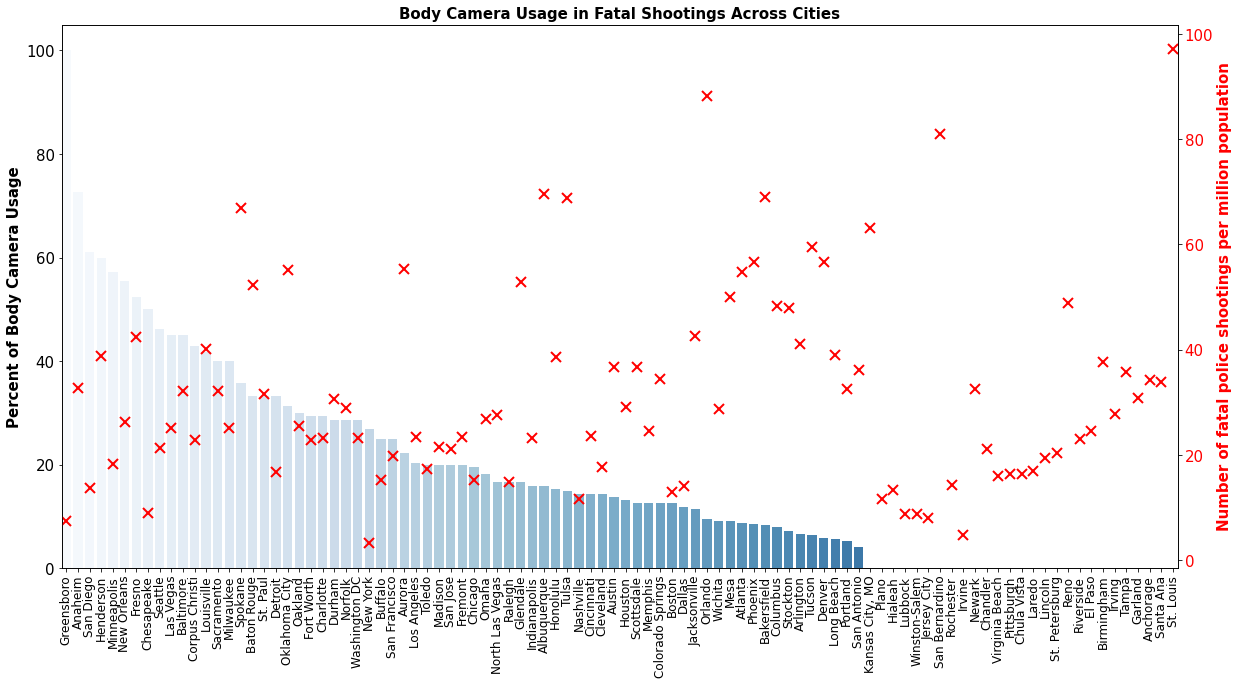

In [145]:
# display sorted bar graph of percent_body_cam_used in descending order of states
fig,ax=plt.subplots(figsize=(20,10))
order = city_df.sort_values(by='percent body cam used',ascending=False)
sns.barplot(x=order['Police Department'].values,y=order['percent body cam used'].values, ax=ax, palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=12);
ax.set_xlabel('')
ax.margins(x=0)
ax.set_ylabel('Percent of Body Camera Usage',fontweight='bold',fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Body Camera Usage in Fatal Shootings Across Cities',fontweight='bold',fontsize=15);
# draw a horizontal line of overall avg in the dataset
#ax.axhline(y=overall_percent_body_cam,color='k',label='Overall Percentage of Body Camera Usage')
#ax.legend(fontsize=15);

# second y axis showing shootings per million population 
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(order['Police Department'].values,order['shootings per 1M'].values,'x',color='r',markersize=10,markeredgewidth=2)
ax2.tick_params(axis='y', labelcolor='r',labelsize=15)
ax2.set_ylabel('Number of fatal police shootings per million population',fontweight='bold',fontsize=15,color='r');

plt.savefig('City percent body cam usage blue & red.png')

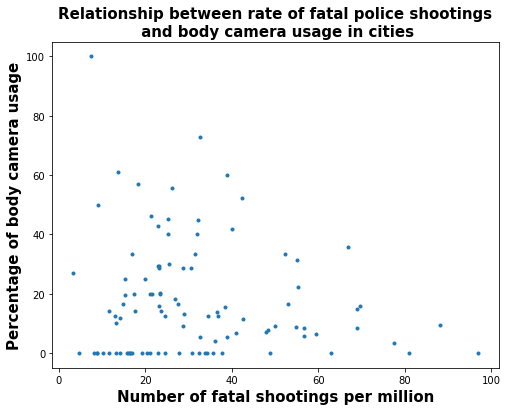

In [32]:
# plot percent body cam used vs shooting per million for cities
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(city_df['shootings per 1M'],city_df['percent body cam used'],'.')
ax.set_title('Relationship between rate of fatal police shootings\n and body camera usage in cities',fontweight='bold',fontsize=15)
ax.set_xlabel('Number of fatal shootings per million',fontweight='bold',fontsize=15)
ax.set_ylabel('Percentage of body camera usage',fontweight='bold',fontsize=15);

In [33]:
r_city=np.corrcoef(city_df['shootings per 1M'],city_df['percent body cam used'])[0,1]
print(f'Correltaion coefficient between number of fatal shootings per million and body camera usage is {r_city:.4f}')

Correltaion coefficient between number of fatal shootings per million and body camera usage is -0.1300


More obvious association at the city level than state level. Probably clearner. 
Caution: may be a little circular. Departments may adopt body cameras at different time points as a remedy to police violence or preventitive measure. No causal realtionship here. 

In [54]:
# display the top 25 cities and their respective shooting numbers in the dataset to get a sense of city-level info
# city_bodycam=wapo.groupby('city').size().to_frame(name='total')
# city_bodycam['body_cam_used']=wapo.groupby('city')['body_camera'].value_counts().unstack(fill_value=0)[True]
# city_bodycam['percent_body_cam_used']=100*city_bodycam['body_cam_used']/city_bodycam['total']

# city_bodycam.sort_values('total',ascending=False).head(20)

**Additional potential analyses:**
- Are there trends with body cam usage in rural/suburban/urban regions? Use present longitude/latitude information to pull out whether a place is rural/suburban/urban regions?
- How does police use of force relate with body cam usage?
- How does body cam usage relate to the crime rate of the state?

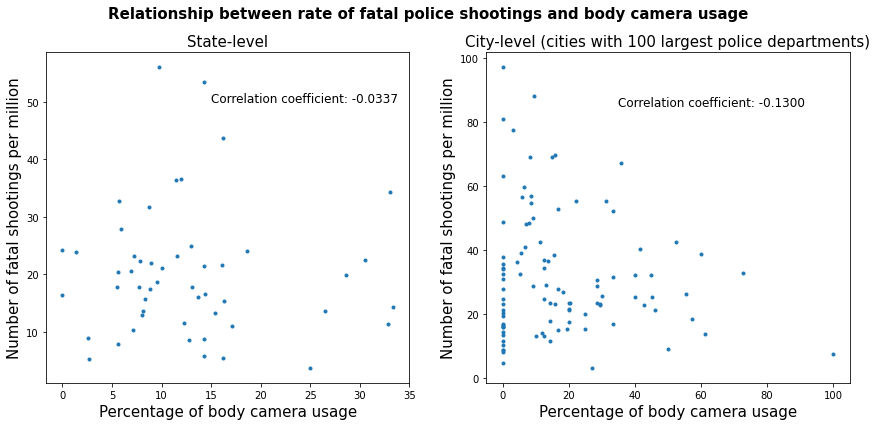

In [34]:
# plot state and city together
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(state_df['percent_body_cam_used'],state_df['num_per_million'],'.')
ax[0].set_title('State-level',fontsize=15)
ax[0].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[0].set_xlabel('Percentage of body camera usage',fontsize=15);
ax[0].text(15,50,f'Correlation coefficient: {r_state:.4f}',fontsize=12)

ax[1].plot(city_df['percent body cam used'],city_df['shootings per 1M'],'.')
ax[1].set_title('City-level (cities with 100 largest police departments)',fontsize=15)
ax[1].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[1].set_xlabel('Percentage of body camera usage',fontsize=15);
ax[1].text(35,85,f'Correlation coefficient: {r_city:.4f}',fontsize=12)

plt.suptitle('Relationship between rate of fatal police shootings and body camera usage',fontweight='bold',fontsize=15)
plt.tight_layout()

plt.savefig('state_city_bodycam.png')

## Part 2: Law Enforcement Management and Administrative Statistics 2016

There are two datasets, one for general LEMAS 2016 (the most recent official release), and the other for body worn camera specifically. First we need to clean the data and may want to merge the two if we want additional info on body worn camera.

In [35]:
# 2016 LEMAS data
lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')
display(lemas_raw.head())
print(lemas_raw.shape)

,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,ORI9,POPSERVED,POPGROUP,AGENCYTYPE,...,NEW_TOT_HIRES,NEW_TOT_SEP,FINALWGT_NTH_NTS,FLAG1,FLAG2,FLAG3,FLAG4,FLAG5,FLAG6,FLAG7
LEAR_ID,,,,,,,,,,,,,,,,,,,,,
635592,DAVIS POLICE DEPARTMENT,DAVIS,95618,CA,YOLO,6113,CA0570100,68111,5,1,...,-9,-9,7.533981,1,0,1,0,0,0,0
645110,WEST NEW YORK POLICE,WEST NEW YORK,7093,NJ,HUDSON,34017,NJ0091200,53343,5,1,...,-9,-9,1.183673,1,0,1,0,0,0,0
631270,WESTOVER POLICE DEPARTMENT,WESTOVER,26501,WV,MONONGALIA,54061,WV0310400,4243,8,1,...,-9,-9,7.607534,1,0,0,0,0,0,0
631316,BARABOO POLICE DEPARTMENT,BARABOO,53913,WI,SAUK,55111,WI0570200,12173,7,1,...,-9,-9,7.225225,1,0,0,0,0,0,0
631684,OREGON POLICE DEPARTMENT,OREGON,53575,WI,DANE,55025,WI0137400,3334,8,1,...,-9,-9,7.347126,1,0,0,0,0,0,0


(2784, 433)


Potentially useful columns:

`LEAR_ID`

`AGENCYNAME`

`CITY`

`STATE`

`COUNTY`

`POPSERVED` - from 2016 census of populations

`FTSWORN` - Number of actual full-time sworn officers with arrest power

`POL_BWC` - AGENCY HAS WRITTEN POLICY OR PROCEDURAL DIRECTIVES ON: BODY-WORN CAMERAS
    
    1 Yes
    
    2 No

`PERS_TRN_ACAD` - TOTAL HOURS OF ACADEMY TRAINING REQUIRED FOR NEW OFFICER RECRUITS

`PERS_TRN_FIELD` - TOTAL HOURS OF FIELD TRAINING REQUIRED FOR NEW OFFICER RECRUITS

`CP_TRN_NEW` - PROPORTION OF AGENCY PERSONNEL RECEIVED AT LEAST EIGHT HOURS OF COMMUNITY POLICING TRAINING: NEW OFFICER RECRUITS (problem solving, SARA, or community partnerships)
    
    1 All
    
    2 Some
    
    3 None

`CP_TRN_INSRV` - PROPORTION OF AGENCY PERSONNEL RECEIVED AT LEAST EIGHT HOURS OF COMMUNITY POLICING TRAINING: IN-SERVICE SWORN PERSONNEL

    1 All
    
    2 Some
    
    3 None


`CP_SURV_TRAINING` -USE INFORMATION FROM SURVEY FOR: TRAINING DEVELOPMENT
    
    1 Yes
    
    2 No
    

`PERS_EDU_MIN `- INDICATE YOUR AGENCY'S MINIMUM EDUCATION REQUIREMENT WHICH NEW OFFICER RECRUITS MUST HAVE AT HIRING OR WITHIN TWO YEARS OF HIRING
    
    1 4-yr college required
    
    2 2-yr college required
    
    3 some college but no degree
    
    4 high school diploma or equivalent
    
    5 no formal education requirement

*-9 denotes missing data*

*-8 means N/A*

In [36]:
# keep only the potentially relevant columns
lemas_columns_to_keep=['AGENCYNAME','CITY','STATE','COUNTY','POPSERVED','FTSWORN','POL_BWC',
                 'PERS_TRN_ACAD','PERS_TRN_FIELD','CP_TRN_NEW','CP_TRN_INSRV','CP_SURV_TRAINING','PERS_EDU_MIN']
lemas=lemas_raw[lemas_columns_to_keep].copy()
lemas.head()
display(lemas.dtypes)

AGENCYNAME          object
CITY                object
STATE               object
COUNTY              object
POPSERVED            int64
FTSWORN              int64
POL_BWC              int64
PERS_TRN_ACAD        int64
PERS_TRN_FIELD       int64
CP_TRN_NEW           int64
CP_TRN_INSRV         int64
CP_SURV_TRAINING     int64
PERS_EDU_MIN         int64
dtype: object

In [37]:
# we know missing data are -9 and -8, replace them with nan
lemas=lemas.replace([-9,-8],np.nan)
lemas.head()

,AGENCYNAME,CITY,STATE,COUNTY,POPSERVED,FTSWORN,POL_BWC,PERS_TRN_ACAD,PERS_TRN_FIELD,CP_TRN_NEW,CP_TRN_INSRV,CP_SURV_TRAINING,PERS_EDU_MIN
LEAR_ID,,,,,,,,,,,,,
635592,DAVIS POLICE DEPARTMENT,DAVIS,CA,YOLO,68111,60,1.0,888.0,900.0,1.0,2.0,1.0,4.0
645110,WEST NEW YORK POLICE,WEST NEW YORK,NJ,HUDSON,53343,110,2.0,805.0,400.0,NaN,3.0,NaN,4.0
631270,WESTOVER POLICE DEPARTMENT,WESTOVER,WV,MONONGALIA,4243,10,1.0,640.0,640.0,1.0,2.0,NaN,4.0
631316,BARABOO POLICE DEPARTMENT,BARABOO,WI,SAUK,12173,28,1.0,720.0,640.0,1.0,1.0,NaN,2.0
631684,OREGON POLICE DEPARTMENT,OREGON,WI,DANE,3334,17,1.0,720.0,490.0,1.0,2.0,NaN,3.0


In [38]:
np.sum(lemas.isnull())

AGENCYNAME             0
CITY                   0
STATE                  0
COUNTY                 0
POPSERVED              0
FTSWORN                0
POL_BWC               17
PERS_TRN_ACAD         45
PERS_TRN_FIELD        52
CP_TRN_NEW           587
CP_TRN_INSRV          56
CP_SURV_TRAINING    2117
PERS_EDU_MIN          26
dtype: int64

Some columns have a lot of missing data, for now let's focus on the more complete columns that are also more relevant: POL_BWC, PERS_TRN_ACAD, PERS_TRN_FIELD, PERS_EDU_MIN

## extract columns related to training

In [39]:
lemas_training=lemas[['AGENCYNAME','CITY','STATE','COUNTY','FTSWORN','PERS_TRN_ACAD','PERS_TRN_FIELD']].copy()
# drop rows with nan (where we don't have information on training data)
lemas_training=lemas_training.dropna(axis=0)
# drop agencies with 0 sworn officers
lemas_training=lemas_training.loc[lemas_training['FTSWORN']>0]
# lemas_training should be clean now
lemas_training

,AGENCYNAME,CITY,STATE,COUNTY,FTSWORN,PERS_TRN_ACAD,PERS_TRN_FIELD
LEAR_ID,,,,,,,
635592,DAVIS POLICE DEPARTMENT,DAVIS,CA,YOLO,60,888.0,900.0
645110,WEST NEW YORK POLICE,WEST NEW YORK,NJ,HUDSON,110,805.0,400.0
631270,WESTOVER POLICE DEPARTMENT,WESTOVER,WV,MONONGALIA,10,640.0,640.0
631316,BARABOO POLICE DEPARTMENT,BARABOO,WI,SAUK,28,720.0,640.0
631684,OREGON POLICE DEPARTMENT,OREGON,WI,DANE,17,720.0,490.0
...,...,...,...,...,...,...,...
645361,LAS VEGAS METRO POLICE DEPARTMENT,LAS VEGAS,NV,CLARK,2566,1070.0,960.0
635749,LOS ANGELES COUNTY SHERIFF'S DEPARTMENT,MONTEREY PARK,CA,LOS ANGELES,9351,880.0,1040.0
638583,CHICAGO POLICE DEPARTMENT,CHICAGO,IL,COOK,11965,917.0,400.0


In [40]:
# for each state, calculate the average trainig hours required for academy and field training for each officer
print(f'Number of states present: {len(lemas_training.STATE.unique())}')
# 50 states + DC

# total number of sworn officers
state_df['sworn_officers']=lemas_training.groupby('STATE')['FTSWORN'].sum()
state_df['avg_training_acad']=''
state_df['avg_training_field']=''

for this_state in lemas_training.STATE.unique():
    total_training_acad=sum(lemas_training.loc[lemas_training['STATE']==this_state]['FTSWORN']\
                            *lemas_training.loc[lemas_training['STATE']==this_state]['PERS_TRN_ACAD'])
    total_training_field=sum(lemas_training.loc[lemas_training['STATE']==this_state]['FTSWORN']\
                            *lemas_training.loc[lemas_training['STATE']==this_state]['PERS_TRN_FIELD'])
    
    state_df.loc[this_state,'avg_training_acad']=total_training_acad/state_df.loc[this_state,'sworn_officers']
    state_df.loc[this_state,'avg_training_field']=total_training_field/state_df.loc[this_state,'sworn_officers']

state_df['avg_training_acad']=state_df['avg_training_acad'].astype(float)
state_df['avg_training_field']=state_df['avg_training_field'].astype(float)

state_df.head()

Number of states present: 51


,total,body_cam_used,percent_body_cam_used,population,num_per_million,sworn_officers,avg_training_acad,avg_training_field
state,,,,,,,,
AK,41,4,9.756098,731545,56.045766,477,896.708595,701.651992
AL,105,15,14.285714,4903185,21.414652,5260,621.734981,516.204563
AR,84,5,5.952381,3017804,27.834810,3202,684.245784,476.430356
AZ,267,32,11.985019,7278717,36.682289,8982,880.287018,600.017813
CA,858,138,16.083916,39512223,21.714799,50495,931.691653,1069.865947


In [41]:
# correlation coefficients
r_train_acad_state=np.corrcoef(state_df['num_per_million'],state_df['avg_training_acad'])[0,1]
r_train_field_state=np.corrcoef(state_df['num_per_million'],state_df['avg_training_field'])[0,1]

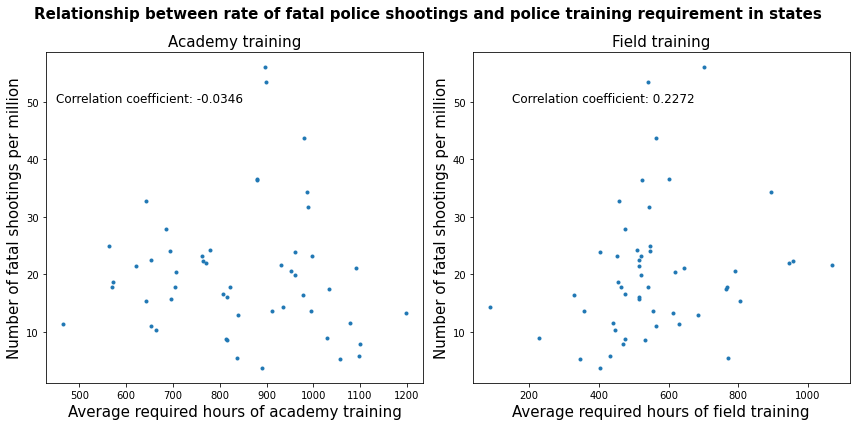

In [42]:
# plot for state level, how academy and field training affect rate of fatal shooting
fig,ax=plt.subplots(1,2,figsize=(12,6))

ax[0].plot(state_df['avg_training_acad'],state_df['num_per_million'],'.')
ax[0].set_title('Academy training',fontsize=15)
ax[0].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[0].set_xlabel('Average required hours of academy training',fontsize=15);
ax[0].text(450,50,f'Correlation coefficient: {r_train_acad_state:.4f}',fontsize=12)

ax[1].plot(state_df['avg_training_field'],state_df['num_per_million'],'.')
ax[1].set_title('Field training',fontsize=15)
ax[1].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[1].set_xlabel('Average required hours of field training',fontsize=15);
ax[1].text(150,50,f'Correlation coefficient: {r_train_field_state:.4f}',fontsize=12)

plt.suptitle('Relationship between rate of fatal police shootings and police training requirement in states',fontweight='bold',fontsize=15)
plt.tight_layout()

plt.savefig('State training and rate of police shooting.png')

In [43]:
# compile city level data on police training and fatal shootings
# use_of_force is currently our city level dataframe (will need to fix naming)

# need to find for cities in use_of_force, corresponding entries in lemas
# note that some cities would be missing due to dropping nan's 

# change the CITY column to be title case to be more consistent 
lemas_training['CITY']=lemas_training['CITY'].str.title()

# first identify mismatches
#mismatched=np.where(1-np.isin(city_df['Police Department'].str.title().values,lemas_training.CITY.values))
#print(city_df['Police Department'].str.title().values[mismatched])


In [46]:
city_df['sworn_officers']=''
city_df['avg_training_acad']=''
city_df['avg_training_field']=''
manual_city=list()
missing_city=list()

for ind, this_city in enumerate(city_df['Police Department'].values):
    if this_city in np.array(lemas_training.CITY): 
        # if there's correct city and state correspondence
        # extract relevant rows of lemas_training
        this_state=city_df['state'].iloc[ind]
        temp_df=lemas_training.loc[(lemas_training['CITY']==this_city) & (lemas_training['STATE']==this_state)].copy()
        if len(temp_df)>0:
            total_training_acad=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_ACAD'])
            total_training_field=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_FIELD'])
            city_df.loc[city_df['Police Department']==this_city,'sworn_officers']=sum(temp_df['FTSWORN'])
            city_df.loc[city_df['Police Department']==this_city,'avg_training_acad']=total_training_acad/sum(temp_df['FTSWORN'])
            city_df.loc[city_df['Police Department']==this_city,'avg_training_field']=total_training_field/sum(temp_df['FTSWORN'])
        else: # city exists but not the right combo with state
            missing_city.append(this_city)
    else: # city may be missing or have mismatched names
         manual_city.append(this_city)

print('Missing cities (no match for city + state combo): ')
print(missing_city)
print('\nManually check: ')
print(manual_city)

Missing cities (no match for city + state combo): 
['Miami']

Manually check: 
['St. Louis', 'Kansas City, MO', 'St. Paul', 'Washington DC', 'St. Petersburg', 'Fort Wayne', 'Philadelphia', 'Winston-Salem']


In [51]:
# check that Miami is indeed missing
display(lemas_training.loc[lemas_training['CITY']=='Miami'][['CITY','STATE']])
display(city_df.loc[city_df['Police Department']=='Miami'][['Police Department','state']])

,CITY,STATE
LEAR_ID,,
650636,Miami,TX


,Police Department,state
56,Miami,FL


In [92]:
# manually fix mismatched cities 
display(city_df.iloc[np.where(np.isin(city_df['Police Department'].values,manual_city))][['Police Department','state']])
display(lemas_training.iloc[np.where(lemas_training.CITY.str.contains('louis|kansas|paul|washington|petersburg|wayne|philadelphia|winston',case=False))])

,Police Department,state
88,St. Louis,MO
44,"Kansas City, MO",MO
89,St. Paul,MN
97,Washington DC,DC
90,St. Petersburg,FL
28,Fort Wayne,IN
69,Philadelphia,PA
99,Winston-Salem,NC


,AGENCYNAME,CITY,STATE,COUNTY,FTSWORN,PERS_TRN_ACAD,PERS_TRN_FIELD
LEAR_ID,,,,,,,
640767,LYNNVIEW POLICE DEPARTMENT,Louisville,KY,,3,880.0,0.0
645201,KANSAS CITY POLICE DEPARTMENT,Kansas City,MO,JACKSON,1364,1020.0,400.0
632821,WASHINGTON CITY POLICE DEPARTMENT,Washington,UT,WASHINGTON,23,520.0,400.0
635102,WASHINGTON POLICE DEPARTMENT,Washington,PA,WASHINGTON,31,758.0,960.0
638166,PAULLINA POLICE DEPARTMENT,Paullina,IA,O'BRIEN,2,602.0,160.0
638900,KANSAS POLICE DEPARTMENT,Kansas,IL,EDGAR,1,400.0,0.0
644170,ST. PAUL POLICE DEPARTMENT,Saint Paul,NE,HOWARD,4,140.0,0.0
645099,WAYNE TOWNSHIP POLICE,Wayne,NJ,PASSAIC,114,960.0,150.0
646962,TUSCARAWAS COUNTY SHERIFF'S OFFICE,New Philadelphia,OH,TUSCARAWAS,35,695.0,320.0


'St.' in city_df is 'Saint' in lemas_training

'Kansas City, MO' is 'Kansas City'

'Washington DC' is 'Washington'

'Winston-Salem' is 'Winston Salem'

'Fort Wayne', 'Philadelphia' are missing

In [100]:
def fix_cities(lemas_city_name,city_df_city_name,state_name):
    temp_df=lemas_training.loc[(lemas_training['CITY']==lemas_city_name) & (lemas_training['STATE']==state_name)].copy()
    total_training_acad=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_ACAD'])
    total_training_field=sum(temp_df['FTSWORN']*temp_df['PERS_TRN_FIELD'])
    city_df.loc[city_df['Police Department']==city_df_city_name,'sworn_officers']=sum(temp_df['FTSWORN'])
    city_df.loc[city_df['Police Department']==city_df_city_name,'avg_training_acad']=total_training_acad/sum(temp_df['FTSWORN'])
    city_df.loc[city_df['Police Department']==city_df_city_name,'avg_training_field']=total_training_field/sum(temp_df['FTSWORN'])
    return city_df

In [103]:
# 'St. Louis'
city_df=fix_cities('Saint Louis','St. Louis','MO')
display(city_df.loc[city_df['Police Department']=='St. Louis'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'St. Paul'
city_df=fix_cities('Saint Paul','St. Paul','MN')
display(city_df.loc[city_df['Police Department']=='St. Paul'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'St. Petersburg'
city_df=fix_cities('Saint Petersburg','St. Petersburg','FL')
display(city_df.loc[city_df['Police Department']=='St. Petersburg'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'Kansas City, MO'
city_df=fix_cities('Kansas City','Kansas City, MO','MO')
display(city_df.loc[city_df['Police Department']=='Kansas City, MO'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'Washington DC'
city_df=fix_cities('Washington','Washington DC','DC')
display(city_df.loc[city_df['Police Department']=='Washington DC'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])

# 'Winston-Salem'
city_df=fix_cities('Winston Salem','Winston-Salem','NC')
display(city_df.loc[city_df['Police Department']=='Winston-Salem'][['Police Department','sworn_officers','avg_training_acad','avg_training_field']])


,Police Department,sworn_officers,avg_training_acad,avg_training_field
88,St. Louis,2011,1061.87,523.839


,Police Department,sworn_officers,avg_training_acad,avg_training_field
89,St. Paul,1448,614.696,626.74


,Police Department,sworn_officers,avg_training_acad,avg_training_field
90,St. Petersburg,537,720,560


,Police Department,sworn_officers,avg_training_acad,avg_training_field
44,"Kansas City, MO",1364,1020,400


,Police Department,sworn_officers,avg_training_acad,avg_training_field
97,Washington DC,3712,960,520


,Police Department,sworn_officers,avg_training_acad,avg_training_field
99,Winston-Salem,216,616,618


In [114]:
# convert these columns to numeric
city_df[['sworn_officers','avg_training_acad','avg_training_field']]\
=city_df[['sworn_officers','avg_training_acad','avg_training_field']].apply(pd.to_numeric,errors='coerce')

# expect 3 missing values for Miami, Fort Wayne, Philaphdelphia
print(np.sum(city_df[['sworn_officers','avg_training_acad','avg_training_field']].isnull()))

# drop rows with nan 
city_df=city_df.dropna(axis=0)
city_df.shape

sworn_officers        0
avg_training_acad     0
avg_training_field    0
dtype: int64


/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(96, 37)

In [119]:
# correlation coefficients
r_train_acad_city=np.corrcoef(city_df['shootings per 1M'],city_df['avg_training_acad'])[0,1]
r_train_field_city=np.corrcoef(city_df['shootings per 1M'],city_df['avg_training_field'])[0,1]

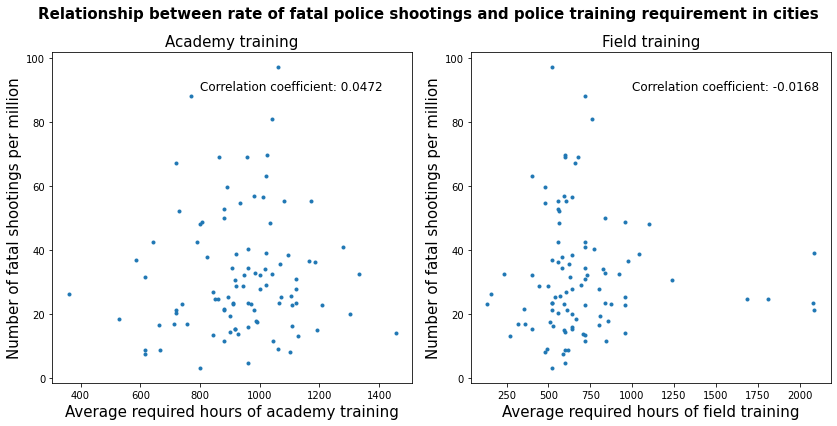

In [124]:
# now we have 96 cities out of 100 with trainig info
# plot for city level, how academy and field training affect rate of fatal shooting
fig,ax=plt.subplots(1,2,figsize=(12,6))

ax[0].plot(city_df['avg_training_acad'],city_df['shootings per 1M'],'.')
ax[0].set_title('Academy training',fontsize=15)
ax[0].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[0].set_xlabel('Average required hours of academy training',fontsize=15);
ax[0].text(800,90,f'Correlation coefficient: {r_train_acad_city:.4f}',fontsize=12)

ax[1].plot(city_df['avg_training_field'],city_df['shootings per 1M'],'.')
ax[1].set_title('Field training',fontsize=15)
ax[1].set_ylabel('Number of fatal shootings per million',fontsize=15)
ax[1].set_xlabel('Average required hours of field training',fontsize=15);
ax[1].text(1000,90,f'Correlation coefficient: {r_train_field_city:.4f}',fontsize=12)

plt.suptitle('Relationship between rate of fatal police shootings and police training requirement in cities',fontweight='bold',fontsize=15)
plt.tight_layout()

plt.savefig('City training and rate of police shooting.png')

## ---------------------------------SKIP THE REST FOR NOW-------------------------------------------

In [89]:
# for POL_BWC replace 2 for no with 0
lemas['POL_BWC']=lemas['POL_BWC'].replace(2,0)
display(lemas['POL_BWC'].unique())

array([ 1.,  0., nan])

In [157]:
# drop nan and group by state
bwc_bypop=lemas[['STATE','POPSERVED','POL_BWC']].dropna(axis=0)
# for each state, we look at the population served by police agencies with and without a written body cam policy
# weigh the POL_BWC column by POPSERVED to get a rough estimate of the state's proportion of agencies with body worn camera policies

bwc_weighted_by_pop=dict()
for this_state in bwc_bypop.STATE.unique(): 
    temp=bwc_bypop.loc[bwc_bypop['STATE']==this_state].groupby('POL_BWC')['POPSERVED'].sum()
    if 1 in temp.index:
        bwc_weighted_by_pop[this_state]=(100*temp.values[temp.index==1]/np.sum(temp.values))[0]
    else:
        bwc_weighted_by_pop[this_state]=0

bwc_weighted_by_pop

{'CA': 67.5734644004085,
 'NJ': 78.065621310658,
 'WV': 6.043164436973666,
 'WI': 23.687598408010526,
 'UT': 25.991419985697956,
 'CO': 27.175384742676798,
 'IN': 16.14937457994096,
 'KS': 30.738556796521447,
 'KY': 19.198863923665243,
 'LA': 79.97779952806016,
 'MO': 14.034892565539808,
 'MS': 6.497651449682897,
 'OK': 77.04716147824679,
 'NC': 27.154085003501127,
 'TX': 86.66536035480571,
 'PA': 11.185479035088097,
 'SC': 79.89066703536167,
 'AR': 68.41562484158338,
 'VA': 23.128550224763124,
 'FL': 25.792854327327827,
 'NY': 31.37982988550754,
 'MI': 11.269629066980029,
 'AL': 77.69671487857785,
 'WA': 13.105053021143167,
 'TN': 17.571643251698283,
 'AZ': 89.04749214880049,
 'GA': 27.425145173978887,
 'HI': 0,
 'IL': 18.220195712905912,
 'MA': 9.24478461394108,
 'MT': 1.9198565232255032,
 'ND': 0.8711211144157742,
 'OH': 78.79488945750506,
 'SD': 8.33319678846469,
 'RI': 12.424255178579855,
 'IA': 13.142423229347184,
 'NM': 23.570692845768562,
 'MD': 22.1462348157629,
 'NE': 70.0466

In [158]:
temp=pd.concat([state_bodycam,pd.Series(bwc_weighted_by_pop)],axis=1)
temp

,total,body_cam_used,percent_body_cam_used,0
AK,41,4,9.756098,0.944266
AL,105,15,14.285714,77.696715
AR,84,5,5.952381,68.415625
AZ,266,30,11.278195,89.047492
CA,854,132,15.456674,67.573464
CO,209,23,11.004785,27.175385
CT,21,3,14.285714,84.208144
DC,14,4,28.571429,100.000000
DE,13,2,15.384615,99.973853
FL,382,21,5.497382,25.792854


Text(0.5, 1.0, 'Relationship between body camera usage in fatal shootings and prevelance of body camera policies in states')

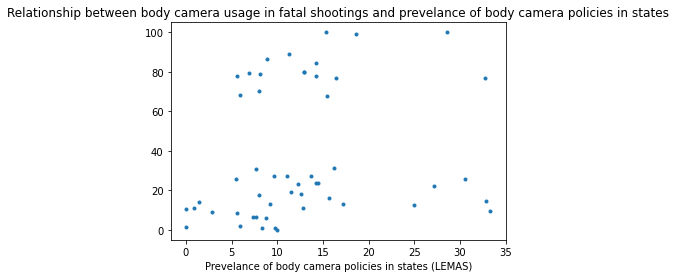

In [161]:
plt.plot(temp['percent_body_cam_used'],temp[0],'.')
plt.xlabel('Percentage of body camera usage in fatal shootings (WaPo)')
plt.xlabel('Prevelance of body camera policies in states (LEMAS)')
plt.title('Relationship between body camera usage in fatal shootings and prevelance of body camera policies in states')

In [163]:
np.corrcoef(temp['percent_body_cam_used'],temp[0])

array([[1.        , 0.18904857],
       [0.18904857, 1.        ]])

In [84]:
# visualize how this relates to the WaPo data in terms of total number of fatal shootings and percent_body_cam_used
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[1]=plt.plot(state_bodycam['total']

,total,body_cam_used,percent_body_cam_used
state,,,
AK,41,4,9.756098
AL,105,15,14.285714
AR,84,5,5.952381
AZ,266,30,11.278195
CA,854,132,15.456674
CO,209,23,11.004785
CT,21,3,14.285714
DC,14,4,28.571429
DE,13,2,15.384615


### Additional data on body-worn camera

*Another can of worms we probably don't want to open*

In [19]:
# read the tsv file into dataframe
bwc_raw = pd.read_csv('data/body_worn_camera.tsv', sep = '\t', header = 0, index_col = 'LEAR_ID', encoding = 'unicode_escape')
display(bwc_raw.head())
print(bwc_raw.shape)

,AGENCY_NAME,ADDRESS1,CITY,AGENCY_STATE,ZIP,COUNTY,FIPS,ORI9,SAMPTYPE,STRATA,...,Q_69,Q_70,Q_71,Q_72A,Q_72B,Q_72C,Q_72D,Q_72E,Q_72F,FINALWEIGHT
LEAR_ID,,,,,,,,,,,,,,,,,,,,,
288574,TEXAS DEPARTMENT OF PUBLIC SAFETY,PO BOX 4087,AUSTIN,TX,78773,,,,5,301,...,232,7,7,1,0,1,5,0,0,1.000000
289378,SPRING CITY POLICE DEPARTMENT,PO BOX 189,SPRING CITY,UT,84662,SANPETE,49039,UT0201200,3,105,...,0,0,0,0,0,0,0,0,0,5.134615
344117,TIADAGHTON VALLEY REGIONAL POLICE DEPARTMENT,129 PENNSYLVANIA AVE,JERSEY SHORE,PA,17740,LYCOMING,42081,,3,104,...,0,-9,0,0,0,0,0,0,0,4.618497
423445,WAVERLY TOWNSHIP POLICE DEPARTMENT,PO BOX 8,WAVERLY,PA,18471,LACKAWANNA,42069,,3,106,...,0,0,0,0,0,0,0,0,0,5.286041
425567,VILLAGE OF BRIARCLIFF POLICE DEPARTMENT,302 SLEAT DR,BRIARCLIFF,TX,78669,,48453,,3,107,...,0,0,0,0,0,0,0,0,0,6.661157


(3928, 259)


The column names refer to questions on the suvey. Not all questions are answered by all agencies. Will need to drop some entries. 

There are lots of categorical variables.

*Note that since the data is from 2016, it would be most fair to compare to the WaPo data of fatal police shootings in 2016.*

The original data contains a lot of columns that are not directly relevant, and the column names are not helpful. We can extract relevant information into a new dataframe. 
*Should probably rename columns later*

Potentially useful columns:

`LEAR_ID` - identifier of police agencies

`AGENCY_NAME`

`CITY`

`AGENCY_STATE`

`COUNTY`

`Q_8` - What is the approximate number of full-time sworn officers with general arrest powers? (numerical)
    
    Missing values were already imputed with previous reports from the same agencies.

`Q_13` - How would you describe the current state of body-worn camera deployment in your agency? (ordinal)

    1 Exploratory/pilot deployment
    
    2 Partial deployment

    3 Complete deployment for some assignments/partial deployment in others

    4 Full deployment to all intended personnel

    -9 Missing

    77 Unsure/don't know


`Q_18` - Does your agency use body-worn camera footage to inform and/or develop in-service training? (categorical)
    
    1 Yes 
    
    2 No
    
    -9 Missing
    
    77 Unsure/don't know
    
    . No body-worn camera
    

`Q_21` - Does your agency’s body-worn camera (or related) policy cover what events to record?
    
    1 Yes 
    
    2 No
    
    -9 Missing
    
    -8 N/A 
    
    77 Unsure/don't know
    
    . No body-worn camera
    

`Q_27` - Have body-worn cameras been deployed to officers in your agency? (categorical)
    
    1 Yes 
    
    2 No
    
    -9 Missing
    
    77 Unsure/don't know
    
    . No body-worn camera
    

`Q_60` - the greatest obstacle in using body cameras

    1 Concerns about the security of the information contained in the videos
    
    2 Concerns about procedures surrounding storage of the videos
    
    3 Concerns about privacy
    
    4 Concerns about liability

    5 Costs were greater than anticipated

    6 Burden of replying to public/agency requests for video data

    7 Lack of public support

    8 Lack of officer support
    
    9 Lack of support from labor union or other group representing officers
    
    10 Cameras use has not benefited the agency as expected
    
    11 Technical obstacles to implementation (e.g., poor video or sound quality)
    
    12 Other
    
    -9 Missing
    
    77 Unsure/don't know
    
    . No body-worn camera
   

`Q_71` - total allegations of civilian complaints reporting excessive use of physical force (numerical)
    
    -9 missing
    
    -8 N/A 


In [20]:
bwc_columns_to_keep=['AGENCY_NAME','CITY','AGENCY_STATE','COUNTY','Q_8','Q_13','Q_18','Q_21','Q_27','Q_60','Q_71']
bwc=bwc_raw[bwc_columns_to_keep].copy()
display(bwc.head())
print(bwc.shape)
display(bwc.dtypes)

,AGENCY_NAME,CITY,AGENCY_STATE,COUNTY,Q_8,Q_13,Q_18,Q_21,Q_27,Q_60,Q_71
LEAR_ID,,,,,,,,,,,
288574,TEXAS DEPARTMENT OF PUBLIC SAFETY,AUSTIN,TX,,3787,2,2,1,1,2,7
289378,SPRING CITY POLICE DEPARTMENT,SPRING CITY,UT,SANPETE,0,,,,,,0
344117,TIADAGHTON VALLEY REGIONAL POLICE DEPARTMENT,JERSEY SHORE,PA,LYCOMING,10,,,,,,0
423445,WAVERLY TOWNSHIP POLICE DEPARTMENT,WAVERLY,PA,LACKAWANNA,3,,,,,,0
425567,VILLAGE OF BRIARCLIFF POLICE DEPARTMENT,BRIARCLIFF,TX,,1,1,2,1,2,-9,0


(3928, 11)


AGENCY_NAME     object
CITY            object
AGENCY_STATE    object
COUNTY          object
Q_8              int64
Q_13            object
Q_18            object
Q_21            object
Q_27            object
Q_60            object
Q_71             int64
dtype: object

In [27]:
# convert datatype to numeric, force non-mumerical data (empty fields deonoted as .) to nan
bwc[['Q_13','Q_18','Q_21','Q_27','Q_60']] = bwc[['Q_13','Q_18','Q_21','Q_27','Q_60']].apply(pd.to_numeric,errors='coerce')
display(bwc.head())
display(bwc.dtypes)

AGENCY_NAME      object
CITY             object
AGENCY_STATE     object
COUNTY           object
Q_8               int64
Q_13            float64
Q_18            float64
Q_21            float64
Q_27            float64
Q_60            float64
Q_71              int64
dtype: object

In [32]:
# replace all -9, -8, 77 from 'Q_13','Q_18','Q_21','Q_27','Q_60','Q_71' with NaNs
bwc[['Q_13','Q_18','Q_21','Q_27','Q_60']]=bwc[['Q_13','Q_18','Q_21','Q_27','Q_60']].replace([-9,-8,77],np.nan)
display(bwc.head())

In [42]:
# for 'Q_18','Q_21','Q_27', replace 2 (No) with 0
bwc[['Q_18','Q_21','Q_27']]=bwc[['Q_18','Q_21','Q_27']].replace(2,0)
# convert floats to nullible integers
bwc[['Q_13','Q_18','Q_21','Q_27','Q_60']]=bwc[['Q_13','Q_18','Q_21','Q_27','Q_60']].astype('Int64')
display(bwc.head())

,AGENCY_NAME,CITY,AGENCY_STATE,COUNTY,Q_8,Q_13,Q_18,Q_21,Q_27,Q_60,Q_71
LEAR_ID,,,,,,,,,,,
288574,TEXAS DEPARTMENT OF PUBLIC SAFETY,AUSTIN,TX,,3787,2,0,1,1,2,7
289378,SPRING CITY POLICE DEPARTMENT,SPRING CITY,UT,SANPETE,0,<NA>,<NA>,<NA>,<NA>,<NA>,0
344117,TIADAGHTON VALLEY REGIONAL POLICE DEPARTMENT,JERSEY SHORE,PA,LYCOMING,10,<NA>,<NA>,<NA>,<NA>,<NA>,0
423445,WAVERLY TOWNSHIP POLICE DEPARTMENT,WAVERLY,PA,LACKAWANNA,3,<NA>,<NA>,<NA>,<NA>,<NA>,0
425567,VILLAGE OF BRIARCLIFF POLICE DEPARTMENT,BRIARCLIFF,TX,,1,1,0,1,0,<NA>,0


In [46]:
np.sum(bwc.isnull())

AGENCY_NAME        0
CITY               0
AGENCY_STATE       0
COUNTY             0
Q_8                0
Q_13            2074
Q_18            2215
Q_21            2338
Q_27            2060
Q_60            2944
Q_71               0
dtype: int64

Quite some missing data (althought a portion of it is from agencies that did not have any body camera). Need to think more about what to do with them.

In [ ]:
# how does WaPo data on body camera usage correspond with LEMAS data on body camera policy?


TODO:
- Need to normalize by size of police agency, and comebine info from different police agencies in the same state
    - Possible ways: calculate ratio of body cameras to full-time sworn officers with arrest power for each state